## Imports

In [1]:
import os
from operator import itemgetter

import pandas as pd

import gym_donkeycar
import gymnasium as gym
import imageio
import ipywidgets as widgets
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from IPython.display import display
from ipywidgets import HBox, VBox
from matplotlib import pyplot as plt
from PIL import Image
from ruamel.yaml import YAML
from tensorboard import notebook
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from torch import distributions as dist
from torch.distributions import Categorical, Normal
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm

# suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["IMAGEIO_IGNORE_WARNINGS"] = "True"

import gym.spaces as gym_spaces
import gymnasium as gym  # overwrite OpenAI gym
import stable_baselines3 as sb3
from gym_donkeycar.envs.donkey_env import DonkeyEnv
from gymnasium import spaces
from gymnasium.spaces import Box
from stable_baselines3 import A2C, PPO, SAC
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import DummyVecEnv

from src.actor_critic import ContinuousActorCritic
# custom classes and functions
from src.blocks import CategoricalStraightThrough, ConvBlock
from src.categorical_vae import CategoricalVAE
from src.imagination_env import ImaginationEnv
from src.mlp import MLP
from src.preprocessing import grayscale_transform as transform
from src.rssm import RSSM
from src.utils import load_config, save_image_and_reconstruction, to_np

torch.cuda.empty_cache()
%matplotlib inline

## Load the config

In [2]:
config = load_config()

for key in config:
    locals()[key] = config[key]

print(config)

{'device': device(type='cuda', index=0), 'A': 2, 'Z': 1024, 'debug': False, 'log_dir': 'logs/', 'seed': 0, 'toy_env': False, 'exe_path': '/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64', 'env_id': 'donkey-minimonaco-track-v0', 'port': 9091, 'size': [64, 64], 'grayscale': False, 'n_envs': 1, 'start_episode': 1000, 'n_seed_episodes': 1000, 'n_training_episodes': 5000, 'max_episode_steps': 1000, 'max_imagination_episode_steps': 15, 'imagination_timesteps_per_model_update': 200, 'max_grad_norm': 1, 'rssm_lr': 0.0001, 'rssm_l2_regularization': 1e-06, 'batch_size': 1, 'H': 512, 'uniform_ratio': 0.01, 'buffer_size': 50000, 'activation': 'silu', 'num_categoricals': 32, 'num_classes': 32, 'channels': [64, 128, 256, 512, 256], 'kernel_size': 3, 'stride': 2, 'padding': 1, 'conv_bias': False, 'entropyloss_coeff': 0.0, 'decoder_final_activation': 'sigmoid', 'pred_loss_coeff': 1.0, 'dyn_loss_coeff': 0.5, 'rep_loss_coeff': 0.1, 'free_nats': 1.0, 'num_rnn_layers': 1, 'mlp_n_l

## Create the environment

In [3]:
sim_config = {
    "exe_path" : "/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64",
    "port" : 9091,
}
env = gym.make(
    "GymV21Environment-v0",
    env_id=env_id,
    max_episode_steps=1500,
    make_kwargs={
        "conf": sim_config
    }
)

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: max_cte 8.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: host localhost
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
donkey subprocess started
Found path: /home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64


INFO:gym_donkeycar.core.client:connecting to localhost:9091 
/home/till/.local/lib/python3.10/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


loading scene mini_monaco


INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!


## Create the agent

In [35]:
agent = A2C(
    "CnnPolicy",
    env,
    verbose=1,
    tensorboard_log="baseline_logs/"
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


## Train the agent

In [5]:
train_agent = True

if train_agent:
    agent.learn(total_timesteps=500_000)

Logging to baseline_logs/A2C_1
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 93.6     |
|    ep_rew_mean        | 17.1     |
| time/                 |          |
|    fps                | 31       |
|    iterations         | 100      |
|    time_elapsed       | 15       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -2.84    |
|    explained_variance | -1.71    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.299    |
|    std                | 1        |
|    value_loss         | 0.0292   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 95.3     |
|    ep_rew_mean        | 19.8     |
| time/                 |          |
|    fps                | 35       |
|    iterations         | 200      |
|    time_elapsed       | 27       |
|    to

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 24.1     |
|    ep_rew_mean        | 18.8     |
| time/                 |          |
|    fps                | 20       |
|    iterations         | 1400     |
|    time_elapsed       | 348      |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -2.87    |
|    explained_variance | -3.5     |
|    learning_rate      | 0.0007   |
|    n_updates          | 1399     |
|    policy_loss        | -3.96    |
|    std                | 1.02     |
|    value_loss         | 3.12     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 19.6     |
|    ep_rew_mean        | 9.28     |
| time/                 |          |
|    fps                | 19       |
|    iterations         | 1500     |
|    time_elapsed       | 387      |
|    total_timesteps    | 7500     |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 17.9     |
|    ep_rew_mean        | 6.47     |
| time/                 |          |
|    fps                | 15       |
|    iterations         | 2700     |
|    time_elapsed       | 859      |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -2.88    |
|    explained_variance | -9.8     |
|    learning_rate      | 0.0007   |
|    n_updates          | 2699     |
|    policy_loss        | 58.6     |
|    std                | 1.02     |
|    value_loss         | 465      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18       |
|    ep_rew_mean        | 6.54     |
| time/                 |          |
|    fps                | 15       |
|    iterations         | 2800     |
|    time_elapsed       | 897      |
|    total_timesteps    | 14000    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18.2     |
|    ep_rew_mean        | 6.66     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 4000     |
|    time_elapsed       | 1368     |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -2.89    |
|    explained_variance | -138     |
|    learning_rate      | 0.0007   |
|    n_updates          | 3999     |
|    policy_loss        | -12.4    |
|    std                | 1.03     |
|    value_loss         | 20.3     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18.3     |
|    ep_rew_mean        | 6.65     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 4100     |
|    time_elapsed       | 1408     |
|    total_timesteps    | 20500    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18.2     |
|    ep_rew_mean        | 6.63     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 5300     |
|    time_elapsed       | 1878     |
|    total_timesteps    | 26500    |
| train/                |          |
|    entropy_loss       | -2.9     |
|    explained_variance | -4.82    |
|    learning_rate      | 0.0007   |
|    n_updates          | 5299     |
|    policy_loss        | -55      |
|    std                | 1.03     |
|    value_loss         | 264      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18.1     |
|    ep_rew_mean        | 6.57     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 5400     |
|    time_elapsed       | 1918     |
|    total_timesteps    | 27000    |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 18.2      |
|    ep_rew_mean        | 6.65      |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 6600      |
|    time_elapsed       | 2388      |
|    total_timesteps    | 33000     |
| train/                |           |
|    entropy_loss       | -2.89     |
|    explained_variance | -2.94e+04 |
|    learning_rate      | 0.0007    |
|    n_updates          | 6599      |
|    policy_loss        | 2.15e+04  |
|    std                | 1.03      |
|    value_loss         | 2.91e+06  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 18.3      |
|    ep_rew_mean        | 6.62      |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 6700      |
|    time_elapsed       | 2427      |
|    total_t

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18       |
|    ep_rew_mean        | 6.54     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 7900     |
|    time_elapsed       | 2895     |
|    total_timesteps    | 39500    |
| train/                |          |
|    entropy_loss       | -2.89    |
|    explained_variance | -0.244   |
|    learning_rate      | 0.0007   |
|    n_updates          | 7899     |
|    policy_loss        | 469      |
|    std                | 1.03     |
|    value_loss         | 5.44e+03 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18.2     |
|    ep_rew_mean        | 6.6      |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 8000     |
|    time_elapsed       | 2935     |
|    total_timesteps    | 40000    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 19       |
|    ep_rew_mean        | 8.16     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 9200     |
|    time_elapsed       | 3402     |
|    total_timesteps    | 46000    |
| train/                |          |
|    entropy_loss       | -2.89    |
|    explained_variance | -0.569   |
|    learning_rate      | 0.0007   |
|    n_updates          | 9199     |
|    policy_loss        | 809      |
|    std                | 1.03     |
|    value_loss         | 8.36e+03 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 19.4     |
|    ep_rew_mean        | 9        |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 9300     |
|    time_elapsed       | 3438     |
|    total_timesteps    | 46500    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18.1     |
|    ep_rew_mean        | 6.6      |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 10500    |
|    time_elapsed       | 3901     |
|    total_timesteps    | 52500    |
| train/                |          |
|    entropy_loss       | -2.89    |
|    explained_variance | 0.632    |
|    learning_rate      | 0.0007   |
|    n_updates          | 10499    |
|    policy_loss        | -7.7e+03 |
|    std                | 1.03     |
|    value_loss         | 2.2e+04  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18.1     |
|    ep_rew_mean        | 6.59     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 10600    |
|    time_elapsed       | 3941     |
|    total_timesteps    | 53000    |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 18.1      |
|    ep_rew_mean        | 6.59      |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 11800     |
|    time_elapsed       | 4415      |
|    total_timesteps    | 59000     |
| train/                |           |
|    entropy_loss       | -2.89     |
|    explained_variance | 0.62      |
|    learning_rate      | 0.0007    |
|    n_updates          | 11799     |
|    policy_loss        | -2.97e+04 |
|    std                | 1.03      |
|    value_loss         | 1.48e+07  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18.1     |
|    ep_rew_mean        | 6.59     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 11900    |
|    time_elapsed       | 4453     |
|    total_timesteps

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 18.1      |
|    ep_rew_mean        | 6.6       |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 13100     |
|    time_elapsed       | 4927      |
|    total_timesteps    | 65500     |
| train/                |           |
|    entropy_loss       | -2.89     |
|    explained_variance | -6.24     |
|    learning_rate      | 0.0007    |
|    n_updates          | 13099     |
|    policy_loss        | -1.01e+03 |
|    std                | 1.03      |
|    value_loss         | 1.79e+04  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18       |
|    ep_rew_mean        | 6.58     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 13200    |
|    time_elapsed       | 4967     |
|    total_timesteps

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18.1     |
|    ep_rew_mean        | 6.64     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 14400    |
|    time_elapsed       | 5438     |
|    total_timesteps    | 72000    |
| train/                |          |
|    entropy_loss       | -2.89    |
|    explained_variance | -1.29    |
|    learning_rate      | 0.0007   |
|    n_updates          | 14399    |
|    policy_loss        | 355      |
|    std                | 1.03     |
|    value_loss         | 1.94e+03 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18.2     |
|    ep_rew_mean        | 6.64     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 14500    |
|    time_elapsed       | 5478     |
|    total_timesteps    | 72500    |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18.3     |
|    ep_rew_mean        | 7.02     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 15700    |
|    time_elapsed       | 5902     |
|    total_timesteps    | 78500    |
| train/                |          |
|    entropy_loss       | -2.89    |
|    explained_variance | -1.35    |
|    learning_rate      | 0.0007   |
|    n_updates          | 15699    |
|    policy_loss        | 3.6e+04  |
|    std                | 1.03     |
|    value_loss         | 8.24e+04 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 19.2     |
|    ep_rew_mean        | 8.9      |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 15800    |
|    time_elapsed       | 5934     |
|    total_timesteps    | 79000    |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 18.7      |
|    ep_rew_mean        | 7.4       |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 17000     |
|    time_elapsed       | 6366      |
|    total_timesteps    | 85000     |
| train/                |           |
|    entropy_loss       | -2.89     |
|    explained_variance | -0.365    |
|    learning_rate      | 0.0007    |
|    n_updates          | 16999     |
|    policy_loss        | -3.37e+05 |
|    std                | 1.03      |
|    value_loss         | 8.06e+05  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 18.2      |
|    ep_rew_mean        | 6.56      |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 17100     |
|    time_elapsed       | 6406      |
|    total_t

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18       |
|    ep_rew_mean        | 6.58     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 18300    |
|    time_elapsed       | 6880     |
|    total_timesteps    | 91500    |
| train/                |          |
|    entropy_loss       | -2.88    |
|    explained_variance | 0.531    |
|    learning_rate      | 0.0007   |
|    n_updates          | 18299    |
|    policy_loss        | 1.03e+07 |
|    std                | 1.02     |
|    value_loss         | 2.02e+09 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 17.9      |
|    ep_rew_mean        | 6.57      |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 18400     |
|    time_elapsed       | 6920      |
|    total_timesteps    | 9200

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18.1     |
|    ep_rew_mean        | 6.68     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 19600    |
|    time_elapsed       | 7393     |
|    total_timesteps    | 98000    |
| train/                |          |
|    entropy_loss       | -2.87    |
|    explained_variance | 0.67     |
|    learning_rate      | 0.0007   |
|    n_updates          | 19599    |
|    policy_loss        | 6.21e+07 |
|    std                | 1.02     |
|    value_loss         | 8.39e+09 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18.2     |
|    ep_rew_mean        | 6.85     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 19700    |
|    time_elapsed       | 7432     |
|    total_timesteps    | 98500    |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 21.4      |
|    ep_rew_mean        | 12.8      |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 20900     |
|    time_elapsed       | 7864      |
|    total_timesteps    | 104500    |
| train/                |           |
|    entropy_loss       | -2.86     |
|    explained_variance | 0.451     |
|    learning_rate      | 0.0007    |
|    n_updates          | 20899     |
|    policy_loss        | -9.42e+07 |
|    std                | 1.01      |
|    value_loss         | 3.86e+08  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.4     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 21000    |
|    time_elapsed       | 7897     |
|    total_timesteps

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.8     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 22200    |
|    time_elapsed       | 8297     |
|    total_timesteps    | 111000   |
| train/                |          |
|    entropy_loss       | -2.87    |
|    explained_variance | 0.914    |
|    learning_rate      | 0.0007   |
|    n_updates          | 22199    |
|    policy_loss        | 6.84e+04 |
|    std                | 1.02     |
|    value_loss         | 7.6e+03  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.8     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 22300    |
|    time_elapsed       | 8329     |
|    total_timesteps    | 111500   |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.2     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 23500    |
|    time_elapsed       | 8728     |
|    total_timesteps    | 117500   |
| train/                |          |
|    entropy_loss       | -2.85    |
|    explained_variance | -8.42    |
|    learning_rate      | 0.0007   |
|    n_updates          | 23499    |
|    policy_loss        | -4.2e+08 |
|    std                | 1.01     |
|    value_loss         | 5.11e+08 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 23600     |
|    time_elapsed       | 8762      |
|    total_timesteps    | 1180

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.1      |
|    ep_rew_mean        | 14.7      |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 24800     |
|    time_elapsed       | 9160      |
|    total_timesteps    | 124000    |
| train/                |           |
|    entropy_loss       | -2.86     |
|    explained_variance | 0.671     |
|    learning_rate      | 0.0007    |
|    n_updates          | 24799     |
|    policy_loss        | -1.68e+08 |
|    std                | 1.01      |
|    value_loss         | 2.35e+07  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.7     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 24900    |
|    time_elapsed       | 9194     |
|    total_timesteps

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.1      |
|    ep_rew_mean        | 14.7      |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 26100     |
|    time_elapsed       | 9594      |
|    total_timesteps    | 130500    |
| train/                |           |
|    entropy_loss       | -2.84     |
|    explained_variance | 0.956     |
|    learning_rate      | 0.0007    |
|    n_updates          | 26099     |
|    policy_loss        | -2.35e+06 |
|    std                | 1         |
|    value_loss         | 4.38e+04  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.7     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 26200    |
|    time_elapsed       | 9628     |
|    total_timesteps

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22       |
|    ep_rew_mean        | 14.7     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 27400    |
|    time_elapsed       | 10027    |
|    total_timesteps    | 137000   |
| train/                |          |
|    entropy_loss       | -2.84    |
|    explained_variance | 0.804    |
|    learning_rate      | 0.0007   |
|    n_updates          | 27399    |
|    policy_loss        | 6.41e+06 |
|    std                | 1        |
|    value_loss         | 6.63e+06 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 27500     |
|    time_elapsed       | 10059     |
|    total_timesteps    | 1375

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 28700    |
|    time_elapsed       | 10459    |
|    total_timesteps    | 143500   |
| train/                |          |
|    entropy_loss       | -2.82    |
|    explained_variance | 0.612    |
|    learning_rate      | 0.0007   |
|    n_updates          | 28699    |
|    policy_loss        | 6.09e+08 |
|    std                | 0.994    |
|    value_loss         | 1.61e+09 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 28800    |
|    time_elapsed       | 10492    |
|    total_timesteps    | 144000   |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22        |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 30000     |
|    time_elapsed       | 10893     |
|    total_timesteps    | 150000    |
| train/                |           |
|    entropy_loss       | -2.81     |
|    explained_variance | 0.69      |
|    learning_rate      | 0.0007    |
|    n_updates          | 29999     |
|    policy_loss        | -1.08e+09 |
|    std                | 0.989     |
|    value_loss         | 3.03e+07  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 30100    |
|    time_elapsed       | 10926    |
|    total_timesteps

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.7     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 31300    |
|    time_elapsed       | 11327    |
|    total_timesteps    | 156500   |
| train/                |          |
|    entropy_loss       | -2.79    |
|    explained_variance | 0.059    |
|    learning_rate      | 0.0007   |
|    n_updates          | 31299    |
|    policy_loss        | 4.57e+06 |
|    std                | 0.976    |
|    value_loss         | 4.49e+03 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22        |
|    ep_rew_mean        | 14.7      |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 31400     |
|    time_elapsed       | 11361     |
|    total_timesteps    | 1570

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.1      |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 32600     |
|    time_elapsed       | 11762     |
|    total_timesteps    | 163000    |
| train/                |           |
|    entropy_loss       | -2.76     |
|    explained_variance | -8.33     |
|    learning_rate      | 0.0007    |
|    n_updates          | 32599     |
|    policy_loss        | -7.86e+09 |
|    std                | 0.961     |
|    value_loss         | 6.27e+08  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 15        |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 32700     |
|    time_elapsed       | 11795     |
|    total_t

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.2     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 33900    |
|    time_elapsed       | 12197    |
|    total_timesteps    | 169500   |
| train/                |          |
|    entropy_loss       | -2.74    |
|    explained_variance | -11.9    |
|    learning_rate      | 0.0007   |
|    n_updates          | 33899    |
|    policy_loss        | 1.15e+11 |
|    std                | 0.956    |
|    value_loss         | 8.7e+10  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.2     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 34000    |
|    time_elapsed       | 12229    |
|    total_timesteps    | 170000   |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.1      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 35200     |
|    time_elapsed       | 12629     |
|    total_timesteps    | 176000    |
| train/                |           |
|    entropy_loss       | -2.72     |
|    explained_variance | -57.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 35199     |
|    policy_loss        | -3.73e+10 |
|    std                | 0.945     |
|    value_loss         | 2.18e+08  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.8     |
| time/                 |          |
|    fps                | 13       |
|    iterations         | 35300    |
|    time_elapsed       | 12662    |
|    total_timesteps

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.3      |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 36500     |
|    time_elapsed       | 13059     |
|    total_timesteps    | 182500    |
| train/                |           |
|    entropy_loss       | -2.72     |
|    explained_variance | -7.91e+10 |
|    learning_rate      | 0.0007    |
|    n_updates          | 36499     |
|    policy_loss        | -2.54e+12 |
|    std                | 0.946     |
|    value_loss         | 6.31e+12  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.3      |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 13        |
|    iterations         | 36600     |
|    time_elapsed       | 13091     |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 37800     |
|    time_elapsed       | 13493     |
|    total_timesteps    | 189000    |
| train/                |           |
|    entropy_loss       | -2.73     |
|    explained_variance | -79.2     |
|    learning_rate      | 0.0007    |
|    n_updates          | 37799     |
|    policy_loss        | -9.09e+09 |
|    std                | 0.95      |
|    value_loss         | 3.86e+07  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 37900     |
|    time_elapsed       | 13525     |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 39100     |
|    time_elapsed       | 13924     |
|    total_timesteps    | 195500    |
| train/                |           |
|    entropy_loss       | -2.74     |
|    explained_variance | 0.939     |
|    learning_rate      | 0.0007    |
|    n_updates          | 39099     |
|    policy_loss        | -9.47e+09 |
|    std                | 0.955     |
|    value_loss         | 1.31e+05  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.3     |
|    ep_rew_mean        | 15       |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 39200    |
|    time_elapsed       | 13957    |
|    total_timesteps

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.3      |
|    ep_rew_mean        | 15        |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 40400     |
|    time_elapsed       | 14356     |
|    total_timesteps    | 202000    |
| train/                |           |
|    entropy_loss       | -2.72     |
|    explained_variance | 0.415     |
|    learning_rate      | 0.0007    |
|    n_updates          | 40399     |
|    policy_loss        | -2.11e+11 |
|    std                | 0.943     |
|    value_loss         | 6.84e+09  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.4     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 40500    |
|    time_elapsed       | 14389    |
|    total_timesteps

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.3     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 41700    |
|    time_elapsed       | 14790    |
|    total_timesteps    | 208500   |
| train/                |          |
|    entropy_loss       | -2.67    |
|    explained_variance | -13.1    |
|    learning_rate      | 0.0007   |
|    n_updates          | 41699    |
|    policy_loss        | 1.34e+14 |
|    std                | 0.924    |
|    value_loss         | 5.13e+12 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.4      |
|    ep_rew_mean        | 15        |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 41800     |
|    time_elapsed       | 14823     |
|    total_timesteps    | 2090

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22       |
|    ep_rew_mean        | 14.8     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 43000    |
|    time_elapsed       | 15224    |
|    total_timesteps    | 215000   |
| train/                |          |
|    entropy_loss       | -2.66    |
|    explained_variance | -264     |
|    learning_rate      | 0.0007   |
|    n_updates          | 42999    |
|    policy_loss        | 6.1e+11  |
|    std                | 0.919    |
|    value_loss         | 8.75e+11 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 21.8      |
|    ep_rew_mean        | 14.6      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 43100     |
|    time_elapsed       | 15258     |
|    total_timesteps    | 2155

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.3      |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 44300     |
|    time_elapsed       | 15654     |
|    total_timesteps    | 221500    |
| train/                |           |
|    entropy_loss       | -2.62     |
|    explained_variance | 0.672     |
|    learning_rate      | 0.0007    |
|    n_updates          | 44299     |
|    policy_loss        | -3.49e+13 |
|    std                | 0.901     |
|    value_loss         | 2.37e+09  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 44400     |
|    time_elapsed       | 15688     |
|    total_t

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.7     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 45600    |
|    time_elapsed       | 16085    |
|    total_timesteps    | 228000   |
| train/                |          |
|    entropy_loss       | -2.61    |
|    explained_variance | 0.568    |
|    learning_rate      | 0.0007   |
|    n_updates          | 45599    |
|    policy_loss        | 5.23e+14 |
|    std                | 0.894    |
|    value_loss         | 5.81e+12 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.7     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 45700    |
|    time_elapsed       | 16117    |
|    total_timesteps    | 228500   |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.3      |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 46900     |
|    time_elapsed       | 16515     |
|    total_timesteps    | 234500    |
| train/                |           |
|    entropy_loss       | -2.59     |
|    explained_variance | 0.992     |
|    learning_rate      | 0.0007    |
|    n_updates          | 46899     |
|    policy_loss        | -2.36e+13 |
|    std                | 0.886     |
|    value_loss         | 1.24e+09  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.3     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 47000    |
|    time_elapsed       | 16548    |
|    total_timesteps

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.8     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 48200    |
|    time_elapsed       | 16946    |
|    total_timesteps    | 241000   |
| train/                |          |
|    entropy_loss       | -2.61    |
|    explained_variance | 0.257    |
|    learning_rate      | 0.0007   |
|    n_updates          | 48199    |
|    policy_loss        | 3.52e+14 |
|    std                | 0.896    |
|    value_loss         | 7.73e+10 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.3     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 48300    |
|    time_elapsed       | 16978    |
|    total_timesteps    | 241500   |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.4      |
|    ep_rew_mean        | 15        |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 49500     |
|    time_elapsed       | 17375     |
|    total_timesteps    | 247500    |
| train/                |           |
|    entropy_loss       | -2.6      |
|    explained_variance | 0.978     |
|    learning_rate      | 0.0007    |
|    n_updates          | 49499     |
|    policy_loss        | -5.96e+11 |
|    std                | 0.888     |
|    value_loss         | 4.59e+07  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.3     |
|    ep_rew_mean        | 15       |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 49600    |
|    time_elapsed       | 17409    |
|    total_timesteps

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.3      |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 50800     |
|    time_elapsed       | 17806     |
|    total_timesteps    | 254000    |
| train/                |           |
|    entropy_loss       | -2.58     |
|    explained_variance | 0.712     |
|    learning_rate      | 0.0007    |
|    n_updates          | 50799     |
|    policy_loss        | -1.18e+14 |
|    std                | 0.883     |
|    value_loss         | 2.95e+11  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.3     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 50900    |
|    time_elapsed       | 17840    |
|    total_timesteps

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.4     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 52100    |
|    time_elapsed       | 18239    |
|    total_timesteps    | 260500   |
| train/                |          |
|    entropy_loss       | -2.55    |
|    explained_variance | 0.498    |
|    learning_rate      | 0.0007   |
|    n_updates          | 52099    |
|    policy_loss        | 5.01e+13 |
|    std                | 0.87     |
|    value_loss         | 5.47e+09 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.5      |
|    ep_rew_mean        | 15        |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 52200     |
|    time_elapsed       | 18271     |
|    total_timesteps    | 2610

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.2     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 53400    |
|    time_elapsed       | 18671    |
|    total_timesteps    | 267000   |
| train/                |          |
|    entropy_loss       | -2.56    |
|    explained_variance | 0.306    |
|    learning_rate      | 0.0007   |
|    n_updates          | 53399    |
|    policy_loss        | 8.16e+12 |
|    std                | 0.871    |
|    value_loss         | 7.74e+08 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.2     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 53500    |
|    time_elapsed       | 18705    |
|    total_timesteps    | 267500   |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 21.9     |
|    ep_rew_mean        | 14.7     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 54700    |
|    time_elapsed       | 19104    |
|    total_timesteps    | 273500   |
| train/                |          |
|    entropy_loss       | -2.53    |
|    explained_variance | -34.7    |
|    learning_rate      | 0.0007   |
|    n_updates          | 54699    |
|    policy_loss        | 1.86e+13 |
|    std                | 0.862    |
|    value_loss         | 1.87e+09 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 21.9      |
|    ep_rew_mean        | 14.7      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 54800     |
|    time_elapsed       | 19138     |
|    total_timesteps    | 2740

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.8     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 56000    |
|    time_elapsed       | 19535    |
|    total_timesteps    | 280000   |
| train/                |          |
|    entropy_loss       | -2.52    |
|    explained_variance | -25.5    |
|    learning_rate      | 0.0007   |
|    n_updates          | 55999    |
|    policy_loss        | -7.5e+13 |
|    std                | 0.854    |
|    value_loss         | 2.16e+09 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22       |
|    ep_rew_mean        | 14.7     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 56100    |
|    time_elapsed       | 19569    |
|    total_timesteps    | 280500   |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 57300     |
|    time_elapsed       | 19967     |
|    total_timesteps    | 286500    |
| train/                |           |
|    entropy_loss       | -2.55     |
|    explained_variance | 0.473     |
|    learning_rate      | 0.0007    |
|    n_updates          | 57299     |
|    policy_loss        | -2.83e+14 |
|    std                | 0.867     |
|    value_loss         | 6.55e+11  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.3      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 57400     |
|    time_elapsed       | 20000     |
|    total_t

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.8     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 58600    |
|    time_elapsed       | 20398    |
|    total_timesteps    | 293000   |
| train/                |          |
|    entropy_loss       | -2.55    |
|    explained_variance | 0.638    |
|    learning_rate      | 0.0007   |
|    n_updates          | 58599    |
|    policy_loss        | 4.95e+13 |
|    std                | 0.868    |
|    value_loss         | 2.66e+12 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.3     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 58700    |
|    time_elapsed       | 20431    |
|    total_timesteps    | 293500   |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.4      |
|    ep_rew_mean        | 15        |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 59900     |
|    time_elapsed       | 20829     |
|    total_timesteps    | 299500    |
| train/                |           |
|    entropy_loss       | -2.53     |
|    explained_variance | 0.627     |
|    learning_rate      | 0.0007    |
|    n_updates          | 59899     |
|    policy_loss        | -1.32e+14 |
|    std                | 0.861     |
|    value_loss         | 7.5e+10   |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.4      |
|    ep_rew_mean        | 15        |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 60000     |
|    time_elapsed       | 20863     |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 61200     |
|    time_elapsed       | 21262     |
|    total_timesteps    | 306000    |
| train/                |           |
|    entropy_loss       | -2.51     |
|    explained_variance | 0.459     |
|    learning_rate      | 0.0007    |
|    n_updates          | 61199     |
|    policy_loss        | -4.58e+13 |
|    std                | 0.853     |
|    value_loss         | 4.72e+11  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.2     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 61300    |
|    time_elapsed       | 21294    |
|    total_timesteps

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.1      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 62500     |
|    time_elapsed       | 21691     |
|    total_timesteps    | 312500    |
| train/                |           |
|    entropy_loss       | -2.5      |
|    explained_variance | 0.47      |
|    learning_rate      | 0.0007    |
|    n_updates          | 62499     |
|    policy_loss        | -1.04e+11 |
|    std                | 0.847     |
|    value_loss         | 2.66e+07  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.2     |
|    ep_rew_mean        | 14.8     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 62600    |
|    time_elapsed       | 21724    |
|    total_timesteps

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.3      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 63800     |
|    time_elapsed       | 22122     |
|    total_timesteps    | 319000    |
| train/                |           |
|    entropy_loss       | -2.53     |
|    explained_variance | 0.119     |
|    learning_rate      | 0.0007    |
|    n_updates          | 63799     |
|    policy_loss        | -8.32e+11 |
|    std                | 0.861     |
|    value_loss         | 2.22e+10  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 63900     |
|    time_elapsed       | 22156     |
|    total_t

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.3     |
|    ep_rew_mean        | 14.8     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 65100    |
|    time_elapsed       | 22557    |
|    total_timesteps    | 325500   |
| train/                |          |
|    entropy_loss       | -2.53    |
|    explained_variance | -188     |
|    learning_rate      | 0.0007   |
|    n_updates          | 65099    |
|    policy_loss        | -1e+12   |
|    std                | 0.862    |
|    value_loss         | 6.22e+11 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.7      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 65200     |
|    time_elapsed       | 22589     |
|    total_timesteps    | 3260

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.8     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 66400    |
|    time_elapsed       | 22988    |
|    total_timesteps    | 332000   |
| train/                |          |
|    entropy_loss       | -2.5     |
|    explained_variance | -0.984   |
|    learning_rate      | 0.0007   |
|    n_updates          | 66399    |
|    policy_loss        | 4.68e+10 |
|    std                | 0.846    |
|    value_loss         | 3.8e+07  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.7     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 66500    |
|    time_elapsed       | 23021    |
|    total_timesteps    | 332500   |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.6      |
|    ep_rew_mean        | 15.1      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 67700     |
|    time_elapsed       | 23417     |
|    total_timesteps    | 338500    |
| train/                |           |
|    entropy_loss       | -2.51     |
|    explained_variance | 0.962     |
|    learning_rate      | 0.0007    |
|    n_updates          | 67699     |
|    policy_loss        | -4.24e+09 |
|    std                | 0.852     |
|    value_loss         | 2.75e+06  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.6      |
|    ep_rew_mean        | 15.2      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 67800     |
|    time_elapsed       | 23449     |
|    total_t

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.8     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 69000    |
|    time_elapsed       | 23848    |
|    total_timesteps    | 345000   |
| train/                |          |
|    entropy_loss       | -2.5     |
|    explained_variance | 0.565    |
|    learning_rate      | 0.0007   |
|    n_updates          | 68999    |
|    policy_loss        | 3e+10    |
|    std                | 0.849    |
|    value_loss         | 6.07e+08 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.7     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 69100    |
|    time_elapsed       | 23882    |
|    total_timesteps    | 345500   |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.7     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 70300    |
|    time_elapsed       | 24282    |
|    total_timesteps    | 351500   |
| train/                |          |
|    entropy_loss       | -2.53    |
|    explained_variance | 0.97     |
|    learning_rate      | 0.0007   |
|    n_updates          | 70299    |
|    policy_loss        | 1.61e+10 |
|    std                | 0.862    |
|    value_loss         | 3.57e+07 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.7     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 70400    |
|    time_elapsed       | 24316    |
|    total_timesteps    | 352000   |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.7     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 71600    |
|    time_elapsed       | 24714    |
|    total_timesteps    | 358000   |
| train/                |          |
|    entropy_loss       | -2.53    |
|    explained_variance | 0.116    |
|    learning_rate      | 0.0007   |
|    n_updates          | 71599    |
|    policy_loss        | 1.08e+10 |
|    std                | 0.859    |
|    value_loss         | 5.6e+07  |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.1      |
|    ep_rew_mean        | 14.7      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 71700     |
|    time_elapsed       | 24748     |
|    total_timesteps    | 3585

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.1      |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 72900     |
|    time_elapsed       | 25147     |
|    total_timesteps    | 364500    |
| train/                |           |
|    entropy_loss       | -2.52     |
|    explained_variance | 0.791     |
|    learning_rate      | 0.0007    |
|    n_updates          | 72899     |
|    policy_loss        | -3.41e+09 |
|    std                | 0.855     |
|    value_loss         | 6.04e+05  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.3     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 73000    |
|    time_elapsed       | 25179    |
|    total_timesteps

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.5     |
|    ep_rew_mean        | 15       |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 74200    |
|    time_elapsed       | 25576    |
|    total_timesteps    | 371000   |
| train/                |          |
|    entropy_loss       | -2.49    |
|    explained_variance | 0.796    |
|    learning_rate      | 0.0007   |
|    n_updates          | 74199    |
|    policy_loss        | 9.97e+08 |
|    std                | 0.845    |
|    value_loss         | 3.72e+08 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.3      |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 74300     |
|    time_elapsed       | 25610     |
|    total_timesteps    | 3715

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 75500     |
|    time_elapsed       | 26009     |
|    total_timesteps    | 377500    |
| train/                |           |
|    entropy_loss       | -2.44     |
|    explained_variance | -31       |
|    learning_rate      | 0.0007    |
|    n_updates          | 75499     |
|    policy_loss        | -4.14e+12 |
|    std                | 0.823     |
|    value_loss         | 1.87e+11  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.1      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 75600     |
|    time_elapsed       | 26042     |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.3      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 76800     |
|    time_elapsed       | 26440     |
|    total_timesteps    | 384000    |
| train/                |           |
|    entropy_loss       | -2.41     |
|    explained_variance | -199      |
|    learning_rate      | 0.0007    |
|    n_updates          | 76799     |
|    policy_loss        | -5.44e+13 |
|    std                | 0.81      |
|    value_loss         | 5.51e+12  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.3      |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 76900     |
|    time_elapsed       | 26473     |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.3      |
|    ep_rew_mean        | 15        |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 78100     |
|    time_elapsed       | 26870     |
|    total_timesteps    | 390500    |
| train/                |           |
|    entropy_loss       | -2.37     |
|    explained_variance | -359      |
|    learning_rate      | 0.0007    |
|    n_updates          | 78099     |
|    policy_loss        | -1.27e+11 |
|    std                | 0.796     |
|    value_loss         | 2.09e+08  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 78200    |
|    time_elapsed       | 26904    |
|    total_timesteps

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22        |
|    ep_rew_mean        | 14.7      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 79400     |
|    time_elapsed       | 27304     |
|    total_timesteps    | 397000    |
| train/                |           |
|    entropy_loss       | -2.38     |
|    explained_variance | -104      |
|    learning_rate      | 0.0007    |
|    n_updates          | 79399     |
|    policy_loss        | -3.64e+12 |
|    std                | 0.801     |
|    value_loss         | 4.73e+11  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.1      |
|    ep_rew_mean        | 14.7      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 79500     |
|    time_elapsed       | 27336     |
|    total_t

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.2     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 80700    |
|    time_elapsed       | 27735    |
|    total_timesteps    | 403500   |
| train/                |          |
|    entropy_loss       | -2.36    |
|    explained_variance | -48.1    |
|    learning_rate      | 0.0007   |
|    n_updates          | 80699    |
|    policy_loss        | 8.24e+13 |
|    std                | 0.793    |
|    value_loss         | 7.9e+11  |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 80800     |
|    time_elapsed       | 27768     |
|    total_timesteps    | 4040

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 15        |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 82000     |
|    time_elapsed       | 28166     |
|    total_timesteps    | 410000    |
| train/                |           |
|    entropy_loss       | -2.37     |
|    explained_variance | -5.11     |
|    learning_rate      | 0.0007    |
|    n_updates          | 81999     |
|    policy_loss        | -3.02e+11 |
|    std                | 0.794     |
|    value_loss         | 8.68e+09  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.4     |
|    ep_rew_mean        | 15.1     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 82100    |
|    time_elapsed       | 28200    |
|    total_timesteps

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.6      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 83300     |
|    time_elapsed       | 28600     |
|    total_timesteps    | 416500    |
| train/                |           |
|    entropy_loss       | -2.33     |
|    explained_variance | 0.731     |
|    learning_rate      | 0.0007    |
|    n_updates          | 83299     |
|    policy_loss        | -3.72e+12 |
|    std                | 0.782     |
|    value_loss         | 4.84e+08  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.2     |
|    ep_rew_mean        | 14.7     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 83400    |
|    time_elapsed       | 28633    |
|    total_timesteps

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.4      |
|    ep_rew_mean        | 15        |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 84600     |
|    time_elapsed       | 29030     |
|    total_timesteps    | 423000    |
| train/                |           |
|    entropy_loss       | -2.35     |
|    explained_variance | 0.791     |
|    learning_rate      | 0.0007    |
|    n_updates          | 84599     |
|    policy_loss        | -1.14e+10 |
|    std                | 0.789     |
|    value_loss         | 2.5e+06   |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.4     |
|    ep_rew_mean        | 15       |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 84700    |
|    time_elapsed       | 29064    |
|    total_timesteps

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.3     |
|    ep_rew_mean        | 15       |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 85900    |
|    time_elapsed       | 29459    |
|    total_timesteps    | 429500   |
| train/                |          |
|    entropy_loss       | -2.32    |
|    explained_variance | 0.922    |
|    learning_rate      | 0.0007   |
|    n_updates          | 85899    |
|    policy_loss        | 7.83e+09 |
|    std                | 0.778    |
|    value_loss         | 3.66e+06 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.3     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 86000    |
|    time_elapsed       | 29492    |
|    total_timesteps    | 430000   |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.1      |
|    ep_rew_mean        | 14.7      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 87200     |
|    time_elapsed       | 29892     |
|    total_timesteps    | 436000    |
| train/                |           |
|    entropy_loss       | -2.29     |
|    explained_variance | -84.6     |
|    learning_rate      | 0.0007    |
|    n_updates          | 87199     |
|    policy_loss        | -9.79e+11 |
|    std                | 0.765     |
|    value_loss         | 2.79e+08  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22        |
|    ep_rew_mean        | 14.7      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 87300     |
|    time_elapsed       | 29924     |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 88500     |
|    time_elapsed       | 30323     |
|    total_timesteps    | 442500    |
| train/                |           |
|    entropy_loss       | -2.28     |
|    explained_variance | 0.574     |
|    learning_rate      | 0.0007    |
|    n_updates          | 88499     |
|    policy_loss        | -9.67e+14 |
|    std                | 0.763     |
|    value_loss         | 5.8e+12   |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.3     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 88600    |
|    time_elapsed       | 30355    |
|    total_timesteps

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.4     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 89800    |
|    time_elapsed       | 30753    |
|    total_timesteps    | 449000   |
| train/                |          |
|    entropy_loss       | -2.29    |
|    explained_variance | 0.668    |
|    learning_rate      | 0.0007   |
|    n_updates          | 89799    |
|    policy_loss        | 1.47e+14 |
|    std                | 0.767    |
|    value_loss         | 5.1e+10  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.3     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 89900    |
|    time_elapsed       | 30787    |
|    total_timesteps    | 449500   |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.1      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 91100     |
|    time_elapsed       | 31185     |
|    total_timesteps    | 455500    |
| train/                |           |
|    entropy_loss       | -2.31     |
|    explained_variance | 0.441     |
|    learning_rate      | 0.0007    |
|    n_updates          | 91099     |
|    policy_loss        | -1.02e+13 |
|    std                | 0.774     |
|    value_loss         | 3.89e+10  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.3      |
|    ep_rew_mean        | 15        |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 91200     |
|    time_elapsed       | 31218     |
|    total_t

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.3      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 92400     |
|    time_elapsed       | 31616     |
|    total_timesteps    | 462000    |
| train/                |           |
|    entropy_loss       | -2.29     |
|    explained_variance | -12.7     |
|    learning_rate      | 0.0007    |
|    n_updates          | 92399     |
|    policy_loss        | -7.01e+13 |
|    std                | 0.765     |
|    value_loss         | 7.74e+10  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.3     |
|    ep_rew_mean        | 14.8     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 92500    |
|    time_elapsed       | 31649    |
|    total_timesteps

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.3     |
|    ep_rew_mean        | 15       |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 93700    |
|    time_elapsed       | 32046    |
|    total_timesteps    | 468500   |
| train/                |          |
|    entropy_loss       | -2.28    |
|    explained_variance | -107     |
|    learning_rate      | 0.0007   |
|    n_updates          | 93699    |
|    policy_loss        | 1.48e+15 |
|    std                | 0.761    |
|    value_loss         | 1.76e+13 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.3      |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 93800     |
|    time_elapsed       | 32078     |
|    total_timesteps    | 4690

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22        |
|    ep_rew_mean        | 14.6      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 95000     |
|    time_elapsed       | 32478     |
|    total_timesteps    | 475000    |
| train/                |           |
|    entropy_loss       | -2.3      |
|    explained_variance | 0.383     |
|    learning_rate      | 0.0007    |
|    n_updates          | 94999     |
|    policy_loss        | -2.85e+13 |
|    std                | 0.767     |
|    value_loss         | 1.59e+09  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22       |
|    ep_rew_mean        | 14.7     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 95100    |
|    time_elapsed       | 32512    |
|    total_timesteps

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.4      |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 96300     |
|    time_elapsed       | 32909     |
|    total_timesteps    | 481500    |
| train/                |           |
|    entropy_loss       | -2.3      |
|    explained_variance | 0.963     |
|    learning_rate      | 0.0007    |
|    n_updates          | 96299     |
|    policy_loss        | -2.17e+11 |
|    std                | 0.768     |
|    value_loss         | 1.19e+08  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.4      |
|    ep_rew_mean        | 14.9      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 96400     |
|    time_elapsed       | 32943     |
|    total_t

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.3     |
|    ep_rew_mean        | 14.9     |
| time/                 |          |
|    fps                | 14       |
|    iterations         | 97600    |
|    time_elapsed       | 33339    |
|    total_timesteps    | 488000   |
| train/                |          |
|    entropy_loss       | -2.32    |
|    explained_variance | -1.67    |
|    learning_rate      | 0.0007   |
|    n_updates          | 97599    |
|    policy_loss        | 8.35e+11 |
|    std                | 0.776    |
|    value_loss         | 2.5e+07  |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.8      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 97700     |
|    time_elapsed       | 33373     |
|    total_timesteps    | 4885

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.7      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 98900     |
|    time_elapsed       | 33771     |
|    total_timesteps    | 494500    |
| train/                |           |
|    entropy_loss       | -2.29     |
|    explained_variance | 0.397     |
|    learning_rate      | 0.0007    |
|    n_updates          | 98899     |
|    policy_loss        | -2.28e+14 |
|    std                | 0.766     |
|    value_loss         | 1.13e+13  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.2      |
|    ep_rew_mean        | 14.7      |
| time/                 |           |
|    fps                | 14        |
|    iterations         | 99000     |
|    time_elapsed       | 33804     |
|    total_t

In [6]:
save_agent = True

if save_agent:
    # agent.save("baseline_weights/SAC_500k")
    # agent.save_replay_buffer("baseline_weights/SAC_500k_replay_buffer")
    
    agent.save("baseline_weights/A2C_500k")

In [7]:
load_agent = True

if load_agent:
    
    # create the agent
    eval_agent = A2C(
        "CnnPolicy", 
        env,
        #buffer_size=0,
        verbose=1, 
        # tensorboard_log="baseline_logs/"
    )
    
    # load the agent
    eval_agent.load("baseline_weights/A2C_500k")
    # eval_agent.load_replay_buffer("baseline_weights/SAC_500k_replay_buffer")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [8]:
# Evaluate the policy
# sim_config = {
#     "exe_path" : "/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64",
#     "port" : 9091,
# }
# env = gym.make(
#     "GymV21Environment-v0",
#     env_id=env_id,
#     max_episode_steps=10, # 1500
#     make_kwargs={
#         "conf": sim_config
#     }
# )

#mean_reward, std_reward = evaluate_policy(eval_agent, env, n_eval_episodes=3, return_episode_rewards=True, deterministic=True)
#print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

In [44]:
# eval_rewards, eval_lengths = evaluate_policy(eval_agent, env, n_eval_episodes=100, return_episode_rewards=True, deterministic=True)

In [45]:
# np.save("eval_rewards", np.array(eval_rewards))
# np.save("eval_lengths", np.array(eval_lengths))

In [ ]:
# agent = SAC(
#     "CnnPolicy", 
#     env,
#     buffer_size=20_000,
#     verbose=1, 
#     tensorboard_log="logs/")
# 
# eval_callback = EvalCallback(
#     env, 
#     best_model_save_path='weights/', 
#     log_path='logs/', 
#     eval_freq=500,
#     n_eval_episodes=1)
#
# agent.learn(total_timesteps=30_000, callback=eval_callback)

## Plot the training results

In [253]:
metrics = [
    "rollout/ep_rew_mean",     # SAC: ✅, PPO: ✅, A2C: ✅
    "rollout/ep_len_mean",     # SAC: ✅, PPO: ✅, A2C: ✅
    "train/critic_loss",       # SAC: critic_loss, PPO: value_loss, A2C: value_loss
    "train/actor_loss",        # SAC: actor_loss, PPO: policy_gradient_loss, A2C: policy_loss
    "train/entropy_loss",     # SAC: ent_coef_loss, PPO: entropy_loss, A2C: entropy_loss
    "time/fps" # SAC: ✅, PPO: ✅, A2C: ✅
]

baselines = {
    "A2C_500k": "baseline_logs/A2C_500k/events.out.tfevents.1685255857.z.54420.0",
    "SAC_500k": "baseline_logs/SAC_500k/events.out.tfevents.1685211019.z.35749.0",
    "PPO_500k": "baseline_logs/PPO_500k/events.out.tfevents.1685229886.z.44451.0",
}

dataframes = {}

for key, log_file in baselines.items():
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()

    rows = []
    for metric in metrics:
        
        if metric == "train/critic_loss":
            if "PPO" in key or "A2C" in key:
                metric = "train/value_loss"
        
        if metric == "train/actor_loss":
            if "PPO" in key:
                metric = "train/policy_gradient_loss"
            elif "A2C" in key:
                metric = "train/policy_loss"
        
        if metric == "train/entropy_loss":
            if "SAC" in key:
                metric = "train/ent_coef_loss"        
        
        steps = []
        values = []
        for event in event_acc.Scalars(metric):
            steps.append(event.step)
            values.append(event.value)
        rows.append(values)

    df = pd.DataFrame(rows, columns=steps, index=metrics)
    dataframes[key] = df

print("Created dataframes:", list(dataframes.keys()))
    
sac_500k_df = dataframes["SAC_500k"].T
ppo_500k_df = dataframes["PPO_500k"].T
a2c_500k_df = dataframes["A2C_500k"].T

Created dataframes: ['A2C_500k', 'SAC_500k', 'PPO_500k']


In [254]:
sac_500k_df.describe()

,rollout/ep_rew_mean,rollout/ep_len_mean,train/critic_loss,train/actor_loss,train/entropy_loss,time/fps
count,499.000000,499.000000,499.000000,499.000000,499.000000,499.000000
mean,234.751565,240.679259,8.095388,-59.879160,-0.541719,30.168337
std,137.896080,140.550433,10.445240,24.248396,1.267077,6.595279
min,20.483406,27.010000,0.058001,-91.005829,-5.278739,13.000000
25%,150.488663,164.574997,2.007284,-77.356052,-0.801736,33.000000
50%,230.141373,222.960007,3.655457,-66.854950,-0.206064,33.000000
75%,320.011963,302.134995,10.940951,-48.604853,0.135454,34.000000
max,566.910156,732.690002,74.660629,-3.385510,2.265267,34.000000


In [255]:
ppo_500k_df.describe()

,rollout/ep_rew_mean,rollout/ep_len_mean,train/critic_loss,train/actor_loss,train/entropy_loss,time/fps
count,245.000000,245.000000,244.000000,244.000000,244.000000,245.000000
mean,216.162968,104.996703,97.554740,0.031646,-3.891308,39.220408
std,78.878605,42.190616,77.235074,0.031882,0.747757,2.697979
min,6.410642,17.420000,8.318115,-0.013610,-5.313385,34.000000
25%,178.399109,80.830002,54.031732,0.015604,-4.528665,37.000000
50%,197.816803,89.800003,84.741089,0.026521,-3.629382,38.000000
75%,254.583054,114.360001,120.069782,0.040456,-3.382998,40.000000
max,507.403290,270.820007,719.455505,0.321162,-2.797279,51.000000


In [256]:
a2c_500k_df.describe()

,rollout/ep_rew_mean,rollout/ep_len_mean,train/critic_loss,train/actor_loss,train/entropy_loss,time/fps
count,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000
mean,13.541172,21.932595,4.145486e+12,2.861601e+13,-2.614585,13.892000
std,3.338138,5.220790,3.227328e+13,9.647109e+14,0.212078,1.749685
min,6.409784,17.730000,4.071006e-04,-7.313159e+15,-2.906366,13.000000
25%,14.680160,22.020000,1.043342e+06,-2.506334e+11,-2.851720,13.000000
50%,14.836826,22.180000,3.881317e+08,-7.648833e+00,-2.588229,14.000000
75%,14.926145,22.299999,5.463994e+10,7.616254e+10,-2.455687,14.000000
max,33.946270,116.818184,7.410561e+14,2.015315e+16,-2.265965,42.000000


In [257]:
for key, df in dataframes.items():
    print(key)

A2C_500k
SAC_500k
PPO_500k


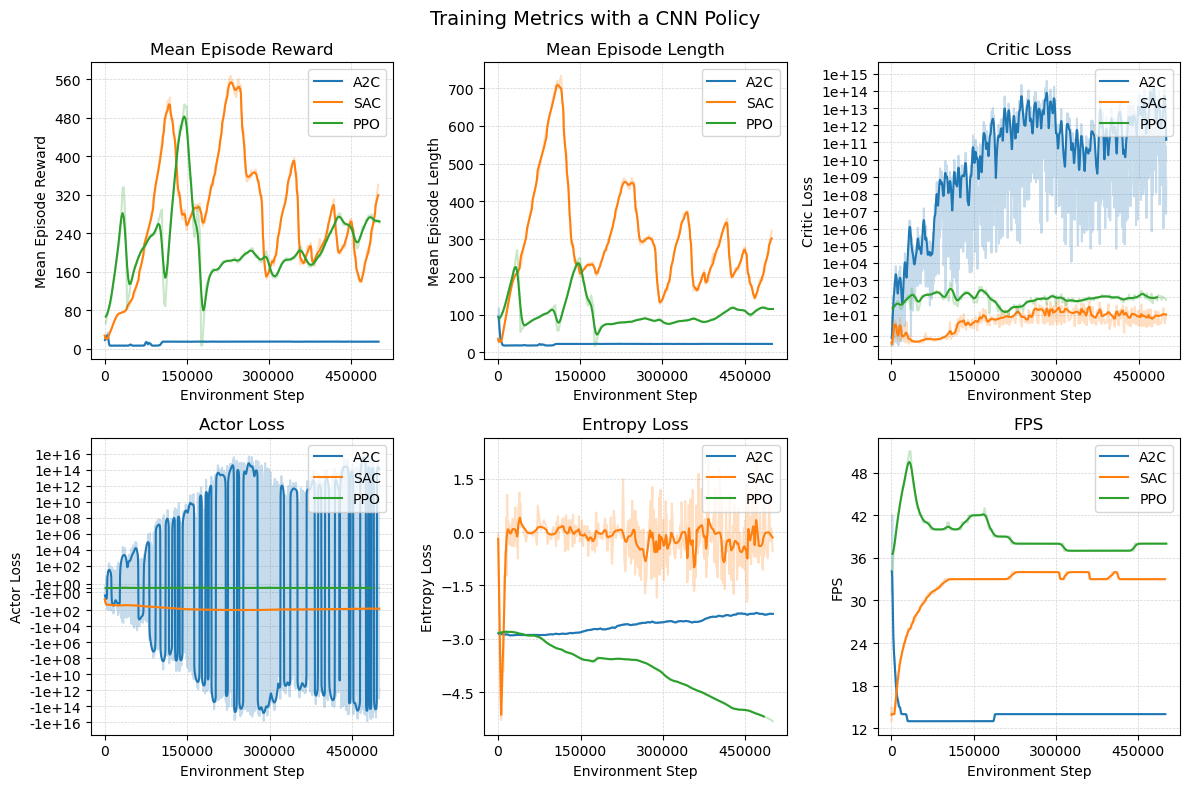

In [260]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

title_dict = {
    "rollout/ep_rew_mean": "Mean Episode Reward",
    "rollout/ep_len_mean": "Mean Episode Length",
    "train/critic_loss": "Critic Loss",
    "train/actor_loss": "Actor Loss",
    "train/entropy_loss": "Entropy Loss",
    "time/fps": "FPS",
}

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle("Training Metrics with a CNN Policy", fontsize=14)

colors = ["tab:blue", "tab:orange", "tab:green"]  # Colors for the smoothed and real values

for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    ax = axs[row, col]

    ax.set_title(title_dict[metric])
    ax.set_ylabel(title_dict[metric])
    ax.set_xlabel('Environment Step')

    for j, (key, df) in enumerate(dataframes.items()):
        steps = df.columns
        values = df.loc[metric]
        
        label = key.split("_")[0] # cut of everything after the first underscore
        
        if "actor_loss" in metric and "A2C" in key:
            smoothed_values = gaussian_filter1d(values, sigma=4) 
        else:
            smoothed_values = gaussian_filter1d(values, sigma=2)
        
        ax.plot(steps, smoothed_values, label=label, alpha=1.0, color=colors[j % len(colors)])  # Plot smoothed values with color cycle
        ax.plot(steps, values, alpha=0.25, color=colors[j % len(colors)])  # Plot real values with lower opacity using the same color
        
        ax.legend(loc="upper right")

    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(8))

    if "critic_loss" in metric or "actor_loss" in metric:
        ax.set_yscale("symlog")
        ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, pos: "{:.0e}".format(x) if x != 0 else None))
        
    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray')
    ax.set_facecolor('white')

plt.tight_layout()
plt.savefig("figs/TrainingMetrics_CnnPolicy.pdf")  
plt.show()

In [228]:
# TODO:
# add a plot for the explained variance for A2C

## Plot the Explained Variance for A2C

In [262]:
metrics = [
    "train/explained_variance", # A2C
]

baselines = {
    "A2C_500k": "baseline_logs/A2C_500k/events.out.tfevents.1685255857.z.54420.0",
}

dataframes = {}

for key, log_file in baselines.items():
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()

    rows = []
    for metric in metrics:
        
        steps = []
        values = []
        for event in event_acc.Scalars(metric):
            steps.append(event.step)
            values.append(event.value)
        rows.append(values)

    df = pd.DataFrame(rows, columns=steps, index=metrics)
    dataframes[key] = df

print("Created dataframes:", list(explvar_dataframes.keys()))

explvar_a2c_500k_df = dataframes["A2C_500k"].T

Created dataframes: ['A2C_500k']


In [263]:
explvar_a2c_500k_df

,train/explained_variance
500,-1.708984
1000,-0.710089
1500,0.552230
2000,0.416900
2500,-0.166477
...,...
498000,-6.368057
498500,0.751526
499000,0.693506
499500,0.747434


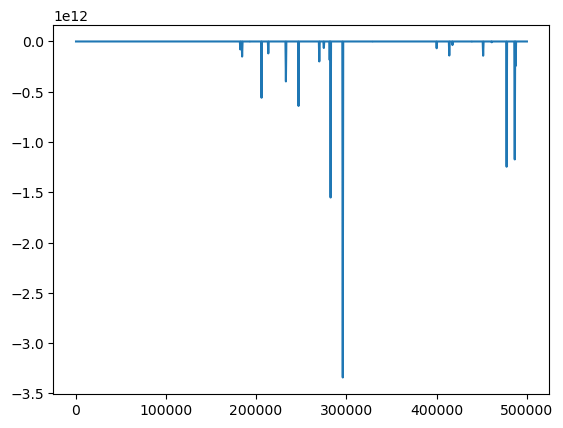

In [264]:
plt.plot(explvar_a2c_500k_df)

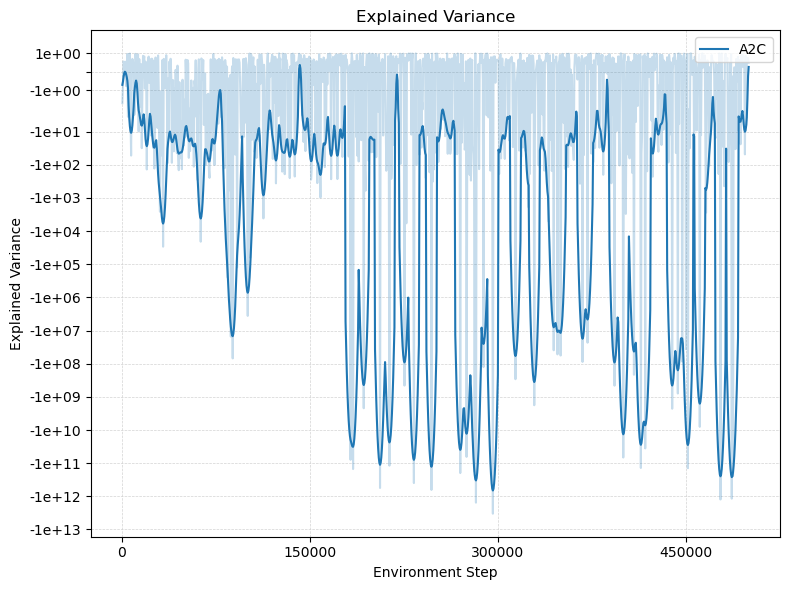

In [265]:
title_dict = {
    "train/explained_variance": "Explained Variance"
}

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

colors = ["tab:blue", "tab:orange", "tab:green"]

metric = "train/explained_variance"
ax = axs

ax.set_title(title_dict[metric])
ax.set_ylabel(title_dict[metric])
ax.set_xlabel('Environment Step')

for j, (key, df) in enumerate(dataframes.items()):
    steps = df.columns
    values = df.loc[metric]

    label = key.split("_")[0]  # Cut off everything after the first underscore

    if "A2C" in key:
        smoothed_values = gaussian_filter1d(values, sigma=2)

    ax.plot(steps, smoothed_values, label=label, alpha=1.0, color=colors[j % len(colors)])
    ax.plot(steps, values, alpha=0.25, color=colors[j % len(colors)])

    ax.legend(loc="upper right")

ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(8))

ax.set_yscale("symlog")
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:.0e}'.format(x) if x != 0 else None))

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray')
ax.set_facecolor('white')

plt.tight_layout()
plt.savefig("figs/ExplainedVariance_A2C.pdf")
plt.show()
